In [6]:
#import necessary lib
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import util
from util import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Naive Bayes Model libs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
data_clean=pd.read_csv('Cleaned_Data_DL.csv')   #Read the clean data
data_clean.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT Optimizing Language Models for Dialogu...,neutral
1,1,Try talking with ChatGPT our new AI system whi...,good
2,2,ChatGPT Optimizing Language Models for Dialogu...,neutral
3,3,THRILLED to share that ChatGPT our new model o...,good
4,4,As of minutes ago OpenAI released their new C...,bad


In [4]:
data_clean['labels'].value_counts()

,count
labels,
bad,106513
good,55655
neutral,55087


Plot saved to data_clean_unbalanced


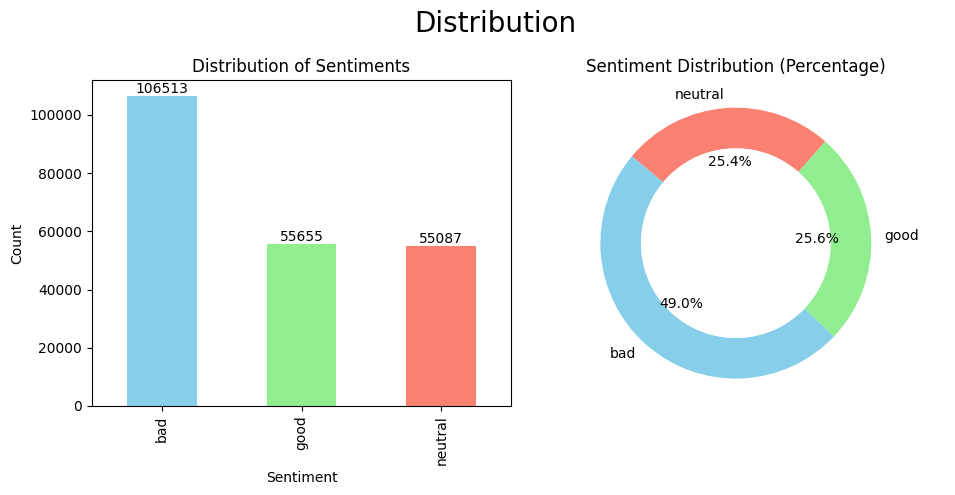

In [5]:
plot_sentiment_distribution(data_clean,'data_clean_unbalanced')    #distribution of unbalanced data

In [8]:
#balancing data with RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
x, y = rus.fit_resample(np.array(data_clean['tweets']).reshape(-1, 1), np.array(data_clean['labels']).reshape(-1, 1))

data_clean_balanced = pd.DataFrame(list(zip([x[0] for x in x], y)), columns=['tweets', 'labels'])
data_clean_balanced.head()

,tweets,labels
0,In the habit of using ChatGPT every day now It...,bad
1,Prompt hacking chatGPT is the AI version of ha...,bad
2,ChatGPT can argue for nuclear warininthe only ...,bad
3,I asked ChatGPT to write code that checks if ...,bad
4,Professors Say ChatGPT Is Writing Terrible Pap...,bad


Plot saved to data_clean_balanced


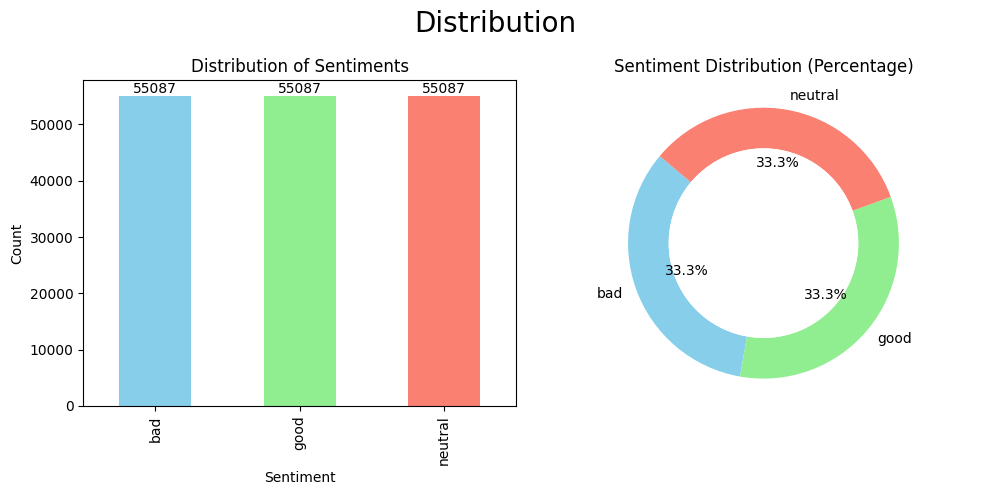

In [7]:
plot_sentiment_distribution(data_clean_balanced,'data_clean_balanced')   #distribution of balanced data (Using undersampling)

In [9]:
mapping = {
    'bad': 0,
    'neutral': 1,
    'good': 2,
}
data_clean_balanced['encoded_label'] = data_clean_balanced['labels'].map(mapping)


In [9]:
data_clean_balanced['encoded_label'].value_counts()

,count
encoded_label,
0,55087
2,55087
1,55087


In [10]:
data_clean_balanced.dropna(inplace=True)   # check for NA
data_clean_balanced.isna().sum()

,0
tweets,0
labels,0
encoded_label,0


In [11]:
#data Preparing train, validation and test
X = data_clean_balanced['tweets'].values
y = data_clean_balanced['encoded_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)   #random_state=42
X_train, X_valid, y_train, y_valid=train_test_split(X_train, y_train, test_size=0.15, random_state=42)   #random_state=42



In [12]:
#One hot encoding
from sklearn import preprocessing
#copy the data
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

ohe = preprocessing.OneHotEncoder()    #onehotencoder
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [13]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 119398
VALIDATION DATA: 21071
TESTING DATA: 24789


In [13]:
#transformers libs
import tensorflow as tf
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [21]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')  #berttokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
#Bert
MAX_LEN=128
#Bert Tokenizer function
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)



In [23]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [4]:
import tensorflow as tf
from transformers import TFBertModel, TFBertForSequenceClassification

#function for Bert and Roberta
def create_model(bert_model, max_len=128):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-5,
        decay_steps=1000,
        decay_rate=0.9
    )

    #optimizer: Adam
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    #loss and metrics: CategoricalCrossentropy
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    #input layers
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name='input_ids')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name='attention_mask')

    outputs = bert_model([input_ids, attention_masks])
    embeddings = outputs[1]


    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)    # the classification output


    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model


In [25]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
model = create_model(bert_model, MAX_LEN)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [26]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=
                         ([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
3732/3732 [==============================] - 1067s 276ms/step - loss: 0.4469 - categorical_accuracy: 0.8181 - val_loss: 0.2960 - val_categorical_accuracy: 0.8949
Epoch 2/4
3732/3732 [==============================] - 1028s 276ms/step - loss: 0.2501 - categorical_accuracy: 0.9106 - val_loss: 0.2465 - val_categorical_accuracy: 0.9145
Epoch 3/4
3732/3732 [==============================] - 1028s 276ms/step - loss: 0.1959 - categorical_accuracy: 0.9319 - val_loss: 0.2402 - val_categorical_accuracy: 0.9190
Epoch 4/4
3732/3732 [==============================] - 1028s 275ms/step - loss: 0.1638 - categorical_accuracy: 0.9443 - val_loss: 0.2332 - val_categorical_accuracy: 0.9251


In [27]:
result_bert = model.predict([test_input_ids,test_attention_masks])

775/775 [==============================] - 70s 86ms/step


In [31]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      8224
           1       0.91      0.88      0.89      8376
           2       0.92      0.95      0.94      8189

    accuracy                           0.93     24789
   macro avg       0.93      0.93      0.93     24789
weighted avg       0.93      0.93      0.93     24789



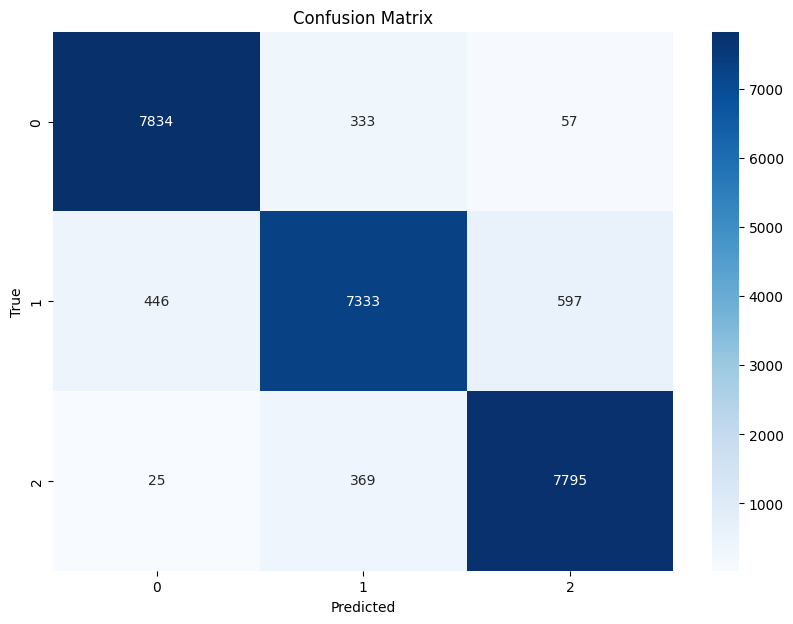

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
y_true_labels = y_test.argmax(1)

y_pred_labels = y_pred_bert.argmax(1)   # Convert the predicted one-hot encoded labels to label indices

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels) #confusion matrix_Bert Model

class_report = classification_report(y_true_labels, y_pred_labels) #classification report_Bert Model
print(class_report)

# CF plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('bert_confusion_matrix_heatmap.png')

plt.show()

In [15]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

129

In [17]:
MAX_LEN=128

In [18]:
def tokenize_roberta(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = tokenizer_roberta.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])


    return np.array(input_ids), np.array(attention_masks)

In [19]:
train_input_ids,train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [20]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [21]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [22]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=
                      ([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4
3980/3980 [==============================] - 1072s 260ms/step - loss: 0.4796 - categorical_accuracy: 0.8004 - val_loss: 0.3216 - val_categorical_accuracy: 0.8815
Epoch 2/4
3980/3980 [==============================] - 1030s 259ms/step - loss: 0.2774 - categorical_accuracy: 0.8949 - val_loss: 0.2694 - val_categorical_accuracy: 0.9020
Epoch 3/4
3980/3980 [==============================] - 1030s 259ms/step - loss: 0.2184 - categorical_accuracy: 0.9195 - val_loss: 0.2472 - val_categorical_accuracy: 0.9126
Epoch 4/4
3980/3980 [==============================] - 1030s 259ms/step - loss: 0.1856 - categorical_accuracy: 0.9331 - val_loss: 0.2420 - val_categorical_accuracy: 0.9166


In [23]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

775/775 [==============================] - 70s 86ms/step


In [24]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      8224
           1       0.91      0.85      0.88      8376
           2       0.90      0.95      0.93      8189

    accuracy                           0.92     24789
   macro avg       0.92      0.92      0.92     24789
weighted avg       0.92      0.92      0.92     24789



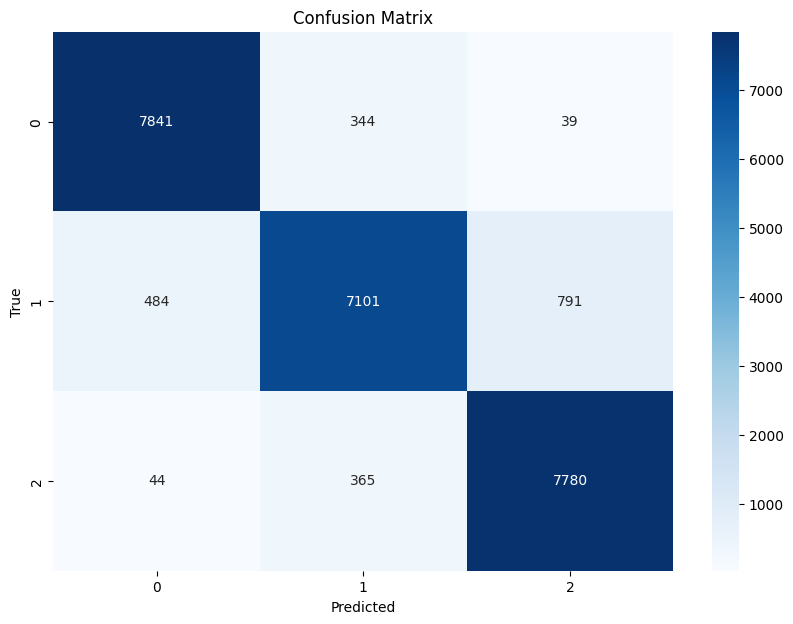

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
y_true_labels = y_test.argmax(1)


y_pred_labels = y_pred_roberta.argmax(1)  #one-hot encoded labels to label indices


conf_matrix = confusion_matrix(y_true_labels, y_pred_labels) #confusion matrix

#classification report
class_report = classification_report(y_true_labels, y_pred_labels)
print(class_report)

#plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


plt.savefig('Roberta1_confusion_matrix_heatmap.png')


plt.show()

In [26]:
#LSTM model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Data preparation
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
V = len(word_index)

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
seq_valid = tokenizer.texts_to_sequences(X_valid)

max_len = max(len(s) for s in seq_train + seq_test + seq_valid)
max_seq_len = int(np.mean([len(s) for s in seq_train + seq_test + seq_valid]) + 2 * np.std([len(s) for s in seq_train + seq_test + seq_valid]))
pad_train = pad_sequences(seq_train, padding='post', maxlen=max_seq_len)
pad_test = pad_sequences(seq_test, padding='post', maxlen=max_seq_len)
pad_valid = pad_sequences(seq_valid, padding='post', maxlen=max_seq_len)

ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1, 1))
y_valid_ohe = ohe.transform(np.array(y_valid).reshape(-1, 1))
y_test_ohe = ohe.transform(np.array(y_test).reshape(-1, 1))

In [27]:
#check data shape
if y_train.shape[1] == 3:
    y_train = np.argmax(y_train, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    y_test = np.argmax(y_test, axis=1)

#one-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1))
y_valid_ohe = ohe.transform(y_valid.reshape(-1, 1))
y_test_ohe = ohe.transform(y_test.reshape(-1, 1))


In [28]:
# LSTM Model: loss='categorical_crossentropy', metrics=['accuracy']

def lstm_model(V, D, maxlen):
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D)(i)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = LSTM(32)(x)
    x = Dropout(0.5)(x)
    x = Dense(y_train_ohe.shape[1], activation='softmax')(x)
    model = Model(i, x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = lstm_model(V, 64, max_seq_len)
model.fit(pad_train, y_train_ohe, validation_data=(pad_valid, y_valid_ohe), epochs=10, batch_size=32)

Epoch 1/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.6737 - loss: 0.7316 - val_accuracy: 0.8396 - val_loss: 0.4517
Epoch 2/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.8637 - loss: 0.4112 - val_accuracy: 0.8673 - val_loss: 0.3868
Epoch 3/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.8920 - loss: 0.3376 - val_accuracy: 0.8796 - val_loss: 0.3594
Epoch 4/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9040 - loss: 0.3026 - val_accuracy: 0.8825 - val_loss: 0.3518
Epoch 5/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9132 - loss: 0.2735 - val_accuracy: 0.8803 - val_loss: 0.3575
Epoch 6/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9219 - loss: 0.2470 - val_accuracy: 0.8780 - val_loss: 0.3785
Epoch 7/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9296 - loss: 0.2229 - val_accuracy: 0.8798 - val_loss: 0.3774
Epoch 8/10
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9367 -

In [36]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
ypred = model.predict(pad_test)


775/775 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

ypred_labels = np.argmax(ypred, axis=1)  #one-hot encoded to class labels
y_test_labels = np.argmax(y_test_ohe, axis=1) #one-hot encoded to class labels

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      8224
           1       0.83      0.81      0.82      8376
           2       0.87      0.90      0.89      8189

    accuracy                           0.87     24789
   macro avg       0.87      0.87      0.87     24789
weighted avg       0.87      0.87      0.87     24789



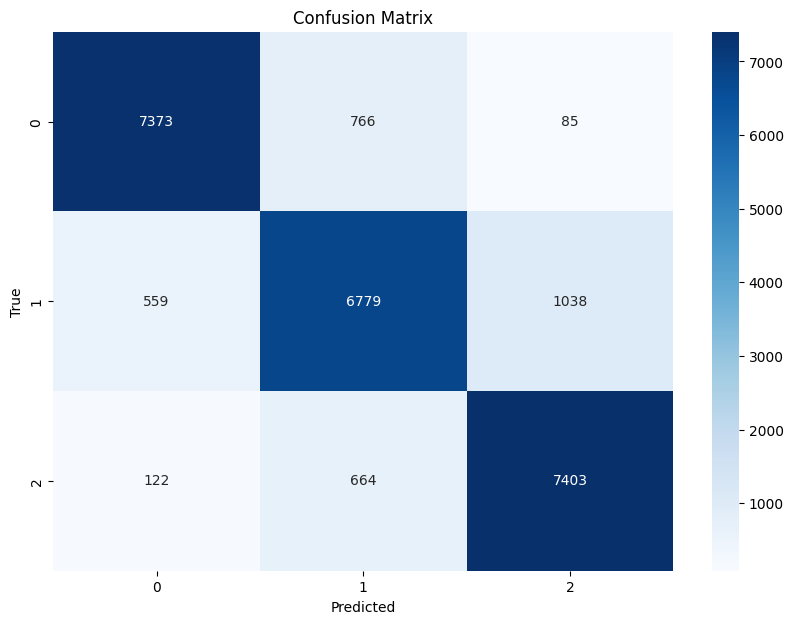

In [38]:
conf_matrix = confusion_matrix(y_test_labels, ypred_labels) #confusion matrix

# classification report
class_report = classification_report(y_test_labels, ypred_labels)
print(class_report)

# confusion matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('LSTM_confusion_matrix_heatmap.png')

plt.show()